# Mathematical Modeling of the Cornea: Applications of Matrix Algebra in Topography

Authors: 
Nate Almanza


**Abstract:**  
This report presents a comprehensive approach to analyzing corneal topography using advanced image processing and matrix algebra techniques. 
By leveraging thresholding algorithms, morphological operations, and ray tracing, we isolate and extract Placido ring patterns from corneal images. 
The extracted data is then transformed into polar coordinates, enabling detailed quantification of ring spacing and corneal surface features. 
Further, we employ Zernike polynomial decomposition to model and interpret the corneal surface, providing insights into its shape and potential aberrations. 
This methodology demonstrates the power of mathematical modeling and computational tools in ophthalmic diagnostics and research.

## Pre Processing: Thresholding using Matrix Arithmatic

#### Otsu's Thresholding Algorithm

**Otsu's Thresholding** is an automatic image thresholding technique used to separate the foreground and background in grayscale images. It finds the threshold value that minimizes the intra-class variance (or equivalently, maximizes the inter-class variance) of the pixel intensities.

1. **Histogram Calculation**: Compute the histogram of the grayscale image, which gives the frequency of each intensity value (0–255 for 8-bit images).

2. **Class Probabilities**: For a threshold value $t$, pixels are divided into two classes:
    - $C_0$: pixels with intensity $\leq t$
    - $C_1$: pixels with intensity $> t$

    The probabilities of each class are:
    
    $\omega_0(t) = \sum_{i=0}^{t} p(i), \quad \omega_1(t) = \sum_{i=t+1}^{L-1} p(i)$

    where $p(i)$ is the normalized histogram (probability of intensity $i$), and $L$ is the number of intensity levels.

3. **Class Means**:
    
    $\mu_0(t) = \frac{1}{\omega_0(t)} \sum_{i=0}^{t} i \cdot p(i), \quad$
    $\mu_1(t) = \frac{1}{\omega_1(t)} \sum_{i=t+1}^{L-1} i \cdot p(i)$

4. **Between-Class Variance**:
    
    $\sigma_b^2(t) = \omega_0(t) \omega_1(t) \left[ \mu_0(t) - \mu_1(t) \right]^2$

5. **Optimal Threshold**: The threshold $t^*$ is chosen to maximize $\sigma_b^2(t)$:
    
    $t^* = \arg\max_t \sigma_b^2(t)$



#### Matrix Manipulation
- The image is represented as a matrix $I$ of pixel intensities.

- The histogram can be computed using matrix operations (e.g., flattening $I$ and counting occurrences).

- The class probabilities and means are weighted sums, which can be expressed as dot products between vectors (histogram and intensity indices).

- The variance calculations involve matrix/vector operations, such as mean subtraction and squaring.


### Isolating the Cornea (Initial Threshold)
The initial Threshold will give us just the pupil which is our area of intrest this limits the error in any future calculation. We can experiment with many thresholding algorithms and tecusing OpenCv to find the one that will give us the best outcome.

- **Otsu's Threshold**

- **Guassian Blur**


**Gaussian Blur** is a widely used image processing technique for smoothing images and reducing noise. It works by convolving the image with a Gaussian kernel, which is a matrix representing the shape of a Gaussian (bell curve) function.

### How Gaussian Blur Works

1. **Gaussian Kernel**:  
   A small matrix (e.g., 3x3, 5x5) whose values are calculated from the 2D Gaussian function:
   
   $G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$
   where $\sigma$ controls the amount of blur.

2. **Convolution**:  
   The kernel is slid over the image. For each pixel, the new value is the weighted sum of its neighbors, where the weights come from the kernel. This operation is a form of matrix multiplication:
   
   $I' = K * I$

   where $I$ is the image matrix, $K$ is the kernel, and $*$ denotes convolution.

3. **Result**:  
   Pixels near the center of the kernel contribute more to the output, causing sharp transitions (like noise or edges) to be smoothed.

- **Image as a Matrix**:  
  The image is a 2D matrix of pixel values.
- **Kernel as a Matrix**:  
  The Gaussian kernel is also a matrix.
- **Convolution as Matrix Operation**:  
  The convolution process is similar to multiplying submatrices of the image by the kernel and summing the results, which is a weighted sum (dot product) — a fundamental matrix operation.
- **Linear Transformation**:  
  Gaussian blur is a linear filter, meaning the output is a linear combination of the input pixels, which is a core concept in matrix algebra.

**Summary:**  
Gaussian blur uses matrix algebra to perform a weighted average of neighboring pixels, smoothing the image by applying a Gaussian kernel through convolution, which is a matrix operation.

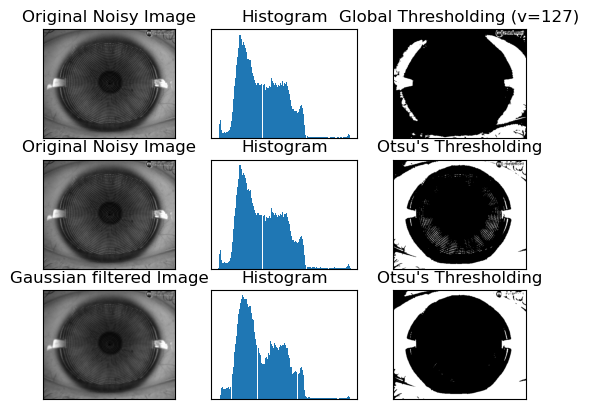

In [377]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('placido_test.png', cv.IMREAD_GRAYSCALE)

assert img is not None, "file could not be read, check with os.path.exists()"
# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,100,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

Now that we have an idea of where the iris is specifically we can focus on this area of intrests cutting down computation time for further analysis and also reducing those larger more persistent artifacts in the image that may corupt any conclusion we come to.

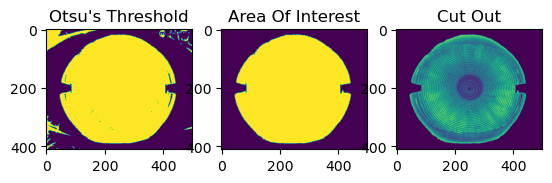

In [378]:
import cv2
import numpy as np

# Invert so black becomes white and vice versa
inverted = cv2.bitwise_not(th3)

contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour by area
largest_contour = max(contours, key=cv2.contourArea)

# Create Mask
mask = np.zeros_like(inverted)
cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# Apply mask to original image or do further calculations only within AOI
refined_aoi = cv2.bitwise_and(img, inverted, mask=mask)

#GRAPHS
figure, axis = plt.subplots(1, 3)
axis[0].imshow(inverted)
axis[0].set_title("Otsu's Threshold")
axis[1].imshow(mask)
axis[1].set_title("Area Of Interest")
axis[2].imshow(refined_aoi)
axis[2].set_title("Cut Out")
plt.show()



Now with this mask we can Isolate the cornea and the rings better, giving us less outliers leading to better interpretations of the placido rings.

# Isolating Placido Ringd, (Secondary Threshold)


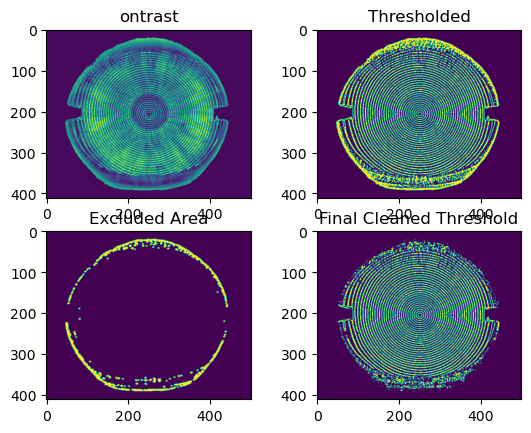

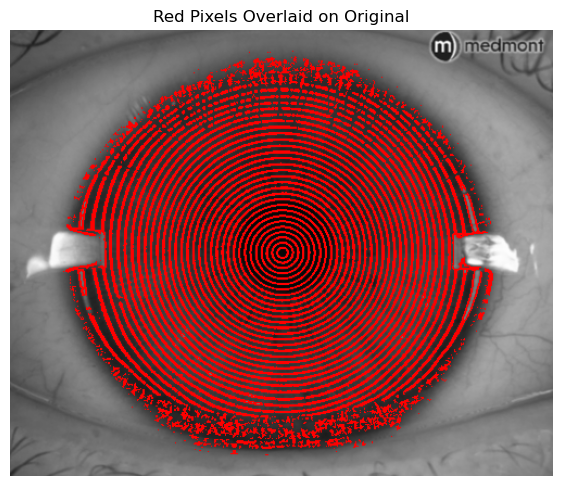

In [379]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Step 1: Enhance contrast with CLAHE
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
enhanced = clahe.apply(refined_aoi)

# Load and pre-process image
blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

# Use adaptive threshold to preserve irregularities
thresh = cv2.adaptiveThreshold(
    enhanced, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 11, 2
)

# invert to capture the lighter rings
thresh = cv2.bitwise_not(thresh)

# AOI
thresh = cv2.bitwise_and(thresh, inverted, mask=mask)
# area we want to remove 
neg_thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
thresh_fin = cv2.bitwise_xor(thresh, neg_thresh)

# Convert grayscale image to BGR
background = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# Make red overlay where thresh == 255
background[thresh_fin == 255] = [0, 0, 255]  # Red pixels

figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].imshow(enhanced)
axis[0, 0].set_title("ontrast")

# For Cosine Function
axis[0, 1].imshow(thresh)
axis[0, 1].set_title("Thresholded")

# For Tangent Function
axis[1, 0].imshow(neg_thresh)
axis[1, 0].set_title("Excluded Area")

# For Tanh Function
axis[1, 1].imshow(thresh_fin)
axis[1, 1].set_title("Final Cleaned Threshold")

# Combine all the operations and display
plt.show()

plt.figure(figsize=(7, 7))
plt.imshow(background[..., ::-1])
plt.title("Red Pixels Overlaid on Original")
plt.axis('off')
plt.show()

## Point Creation and Graphing

Now that we have the rings extracted we can interperet them in many ways, our approach here is to look at the position of the rings and calculate the distance between them to determine corneal topography. 

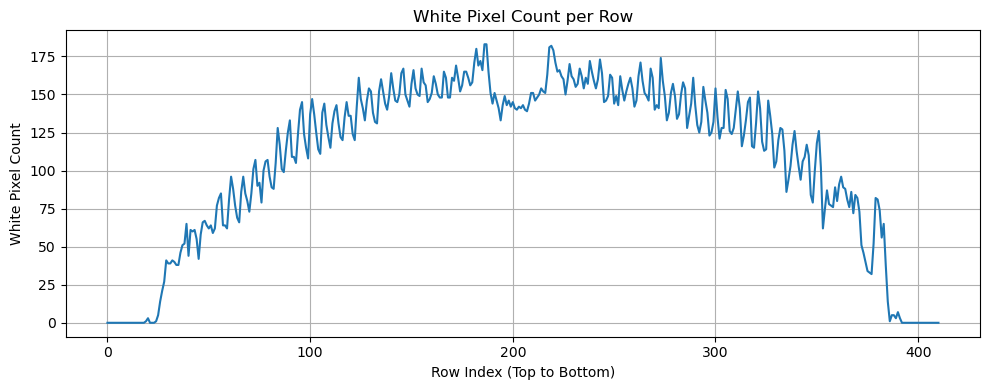

In [380]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

rings = thresh_fin
# Count white pixels (255) in each row
white_pixel_counts = np.sum(rings == 255, axis=1)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(white_pixel_counts)
plt.title("White Pixel Count per Row")
plt.xlabel("Row Index (Top to Bottom)")
plt.ylabel("White Pixel Count")
plt.grid(True)
plt.tight_layout()
plt.show()


This histogram shows us the frequency of the pixels at each row in the image matrix that we have detected this represents the placido ring, the frequency can give us a better understanding of the data. The dips in the graph represent when the ring has ended, or the space in between rings. The spikes in the graph represent the rings themselves where there is a more dense collection of pixels.

NOTE: the valley in the center of our histogram is the notches in the placido cone that obfiscated the rings, we couldnt gather that data and therfore it was left out further cleaning of this data will give us a more consistent picture.

Observing the histogram of white pixels (placido ring) from the image, we can observe that the data we gathered is already lending some helpful information we can deduce the space inbetween the rings by focusing on the dips and the spikes.

# Extracting Points 

Using ray tracing we can virtualize a radial ray projected from the center at an angle from 0 - 360, The ray is projected and goes through the pixel and when it iterates through a pixel with a value greater then 0 we mark it as a hit, and a point is created at that cordinate. 

since the image is already pre processed and the image is already centered we can find the center of the inner most circle easily.

[5.0, 9.5, 14.5, 19.5, 24.5, 30.5, 35.5, 40.5, 45.5, 50.5, 56.0, 61.0, 66.5, 71.5, 76.5, 82.5, 87.5, 93.0, 98.5, 104.0, 109.0, 114.5, 120.0, 125.5, 131.0, 136.5, 142.5, 148.0, 154.5, 158.0]
[4, 5, 6, 9, 10, 14, 15, 19, 20, 24, 25, 30, 31, 35, 36, 40, 41, 45, 46, 50, 51, 55, 56, 57, 60, 61, 62, 66, 67, 71, 72, 76, 77, 82, 83, 87, 88, 92, 93, 94, 98, 99, 103, 104, 105, 108, 109, 110, 114, 115, 119, 120, 121, 125, 126, 130, 131, 132, 136, 137, 142, 143, 147, 148, 149, 154, 155, 158]
[(206, 255), (206, 259), (206, 264), (206, 269), (206, 274), (206, 280), (206, 285), (206, 290), (206, 295), (206, 300), (206, 305), (207, 311), (207, 316), (207, 321), (207, 326), (207, 332), (207, 337), (207, 343), (207, 348), (207, 354), (207, 359), (208, 364), (208, 370), (208, 375), (208, 381), (208, 386), (208, 392), (208, 398), (208, 404), (208, 408)]


Text(0.5, 1.0, 'Polar Ring Analysis')

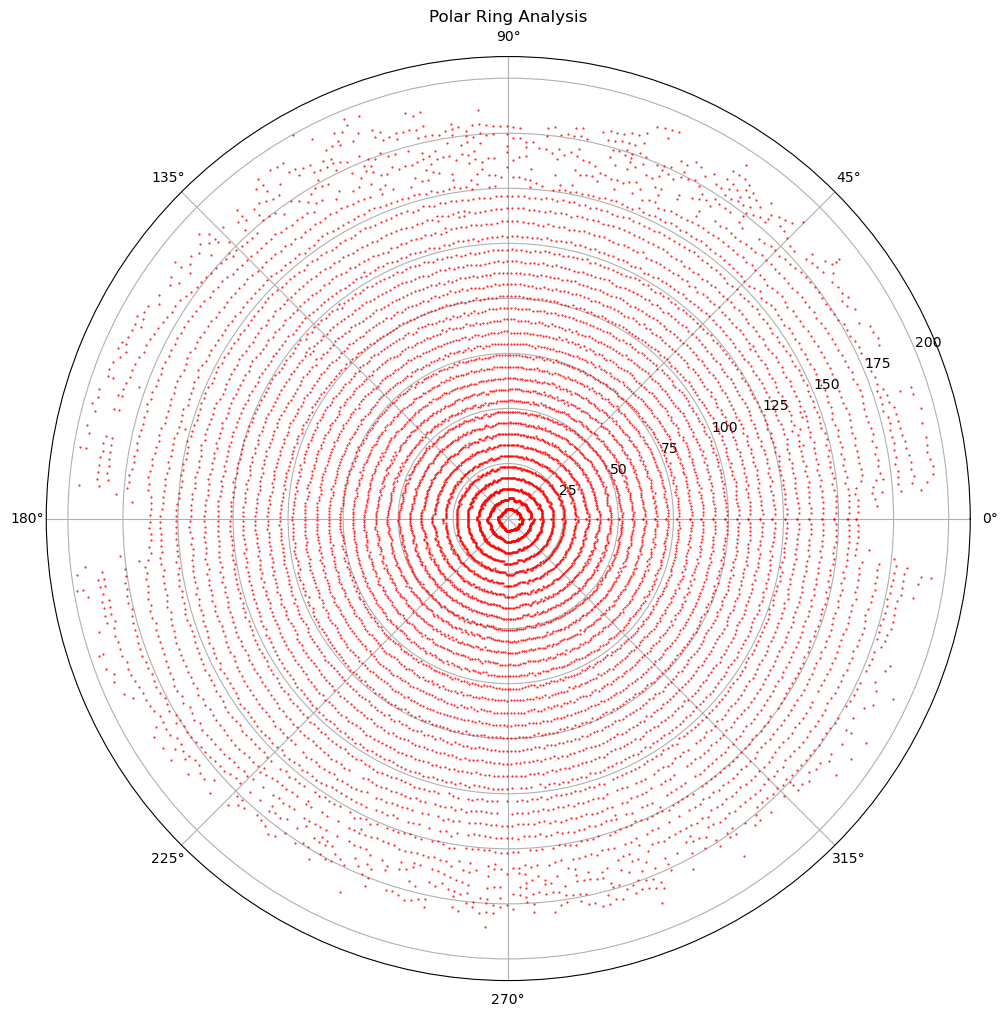

In [381]:
center = (250,206)

def analyze_rings_cartesian(mask, center):
    """Analyze rings and output Cartesian coordinates of detected ring hits"""
    h, w = mask.shape
    angles = np.linspace(0, 2 * np.pi, 360)

    topography_data = []        # Raw radii (per angle)
    binary_strings = []         # Binary strings per ray
    averaged_radii = []         # Averaged concentric rings (per ray)
    cartesian_coords = []       # Final Cartesian coordinates: [mire][angle] = (y, x)

    max_radius = min(h, w) // 2

    for angle in angles:
        radii_at_angle = []
        binary = []
        coords_at_angle = []

        for r in range(0, max_radius, 1):
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))

            if 0 <= x < w and 0 <= y < h:
                if mask[y, x] > 0:  # Hit a ring
                    radii_at_angle.append(r)
                    coords_at_angle.append((y, x))
                    binary.append('1')
                else:
                    binary.append('0')
            else:
                binary.append('0')

        # Group and average consecutive ring hits
        grouped_radii = []
        grouped_coords = []
        current_group = []
        current_coords = []

        for i in range(len(radii_at_angle)):
            if i == 0 or radii_at_angle[i] == radii_at_angle[i - 1] + 1:
                current_group.append(radii_at_angle[i])
                current_coords.append(coords_at_angle[i])
            else:
                if current_group:
                    grouped_radii.append(sum(current_group) / len(current_group))
                    avg_y = int(np.mean([pt[0] for pt in current_coords]))
                    avg_x = int(np.mean([pt[1] for pt in current_coords]))
                    grouped_coords.append((avg_y, avg_x))
                current_group = [radii_at_angle[i]]
                current_coords = [coords_at_angle[i]]

        if current_group:
            grouped_radii.append(sum(current_group) / len(current_group))
            avg_y = int(np.mean([pt[0] for pt in current_coords]))
            avg_x = int(np.mean([pt[1] for pt in current_coords]))
            grouped_coords.append((avg_y, avg_x))

        topography_data.append(radii_at_angle)
        averaged_radii.append(grouped_radii)
        cartesian_coords.append(grouped_coords)
        binary_strings.append(''.join(binary))

    return angles, topography_data, binary_strings, averaged_radii, cartesian_coords

# Analyze in polar coordinates
angles, polar_data, binary_rays, averaged_polar_data, cartesian_coords = analyze_rings_cartesian(rings, center)

print(averaged_polar_data[0])
print(polar_data[0])
print(cartesian_coords[1])

# Create polar plot
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize = (16,12), dpi = 100)
for i, radii_list in enumerate(averaged_polar_data):
    for radius in radii_list:
        ax.plot(angles[i], radius, 'r.', markersize=1)
ax.set_title('Polar Ring Analysis')


We notice that there are many points that are incoherent around the outer edge where the placido rings are reflecting less into the sensor or being blocked by eyelashes. To combat this next we will attempt to preprocess further, getting down to only the most relevant and accurate data points

**NOTE**: The eye has the most reflective power within the cornea, once past the limbus data becomes harder to gather due to its rougher surface. Tear film can also obstruct ring reflection leading to no reflection or warped rings. 
Where tears gather the most is around eyelids and the bottom of the eye so patients are often asked to look up and down when taking measurements of the full cornea and data points are stitched together.

### Indexing and Removal of Artifacts

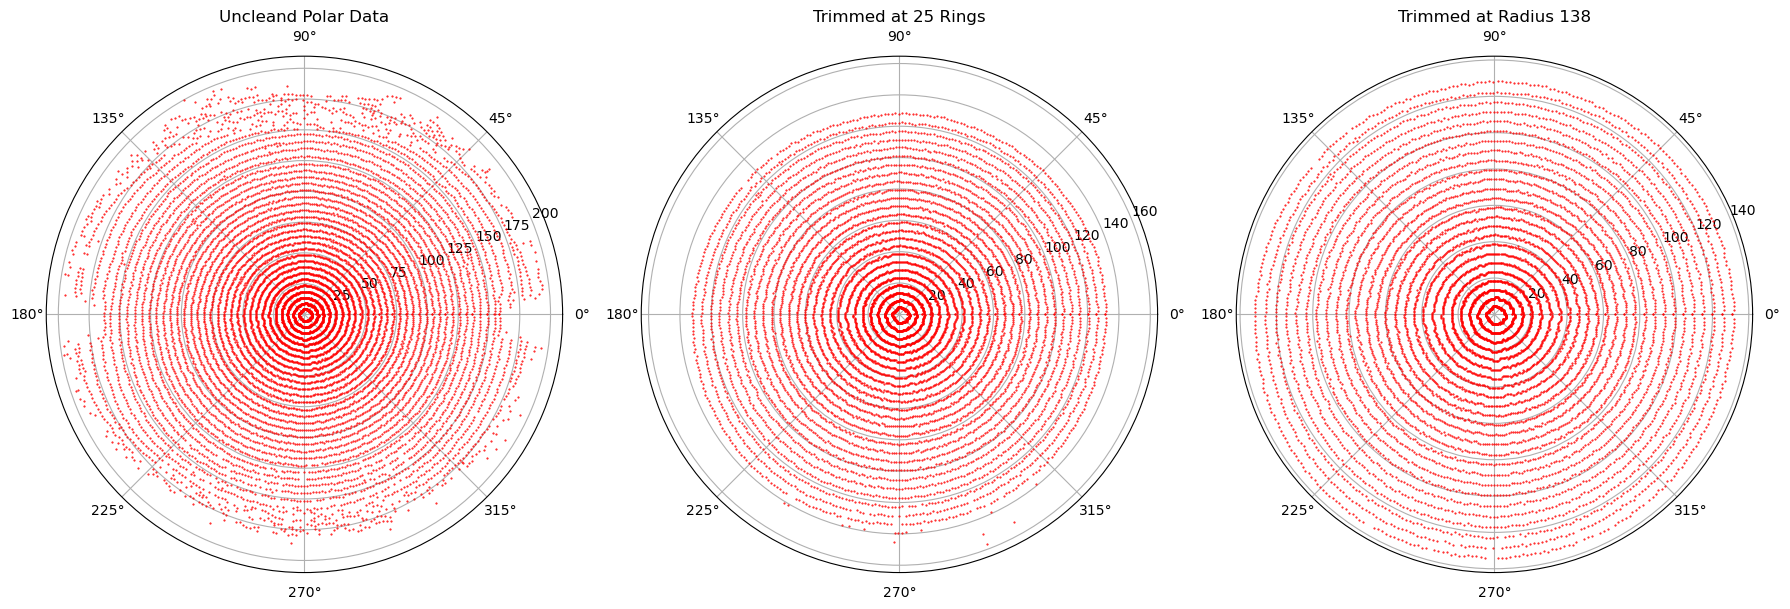

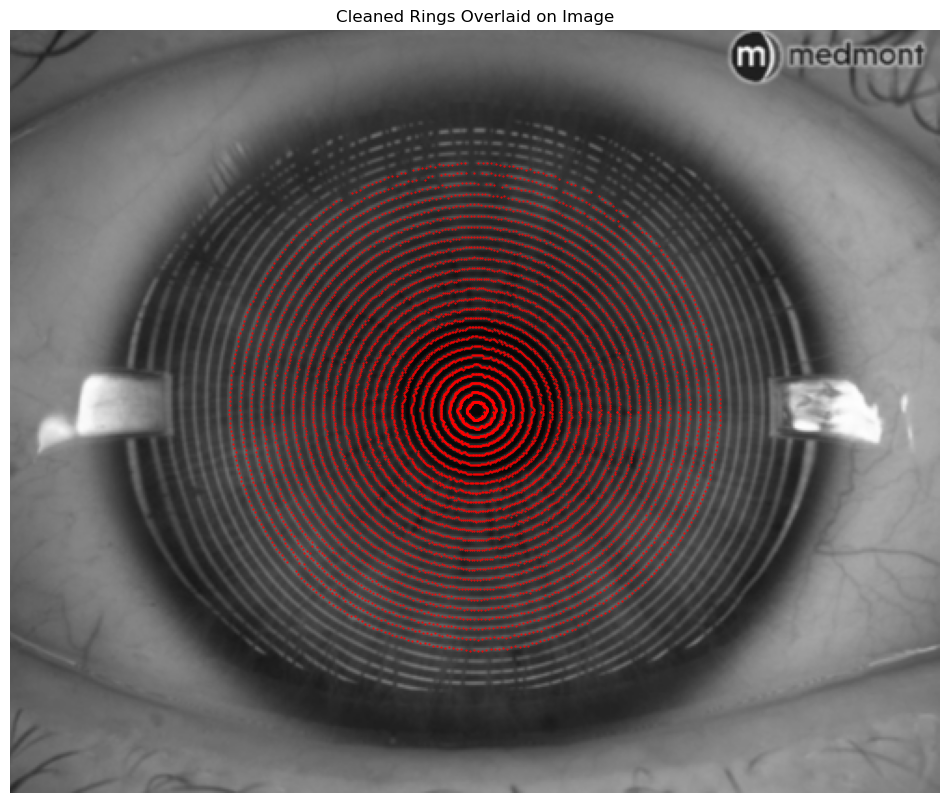

In [382]:
# Function to trim polar data to a maximum number of rings
def trim_polar_data_to_max_rings(polar_data, max_rings=32):
    return [radii[:max_rings] if len(radii) > max_rings else radii for radii in polar_data]

# Function to trim polar data to a maximum radii to remove outliers
def trim_polar_data_to_max_radius(polar_data, max_radius=170):
    """
    Trims each ray in polar_data to only include values <= max_radius.

    Parameters:
    - polar_data: List of lists of radii (each inner list is one ray).
    - max_radius: Maximum radius value allowed.

    Returns:
    - trimmed_data: New list of rays with radii clipped at max_radius.
    """
    return [[r for r in radii if r <= max_radius] for radii in polar_data]

def find_max_radius(polar_data):
    """
    Finds the maximum radius value across all rays in polar_data.

    Parameters:
    - polar_data: List of lists of radii (each inner list is one ray).

    Returns:
    - max_radius: The largest radius value found.
    """
    max_radius = 0
    for radii in polar_data:
        if radii:  # Skip empty rays
            local_max = max(radii)
            if local_max > max_radius:
                max_radius = local_max
    return max_radius

# First three plots stored in a list of figure axes
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(18, 6), dpi=100)

# Plot 1: Raw polar data
for i, radii_list in enumerate(averaged_polar_data):
    for radius in radii_list:
        axs[0].plot(angles[i], radius, 'r.', markersize=1)
axs[0].set_title('Uncleand Polar Data')

# Plot 2: Polar data with trimmed rings 
for i, radii_list in enumerate(trim_polar_data_to_max_rings(averaged_polar_data, max_rings=25)):
    for radius in radii_list:
        axs[1].plot(angles[i], radius, 'r.', markersize=1)
axs[1].set_title('Trimmed at 25 Rings')

# APPLY the trimming function to averaged_polar_data
averaged_polar_data = trim_polar_data_to_max_rings(averaged_polar_data, max_rings=25)
# APPLY 2nd trimming function to averaged_polar_data
averaged_polar_data = trim_polar_data_to_max_radius(averaged_polar_data, max_radius=138)

# Plot 3: Combined Trimmed (first rings + max radius)
for i, radii_list in enumerate(averaged_polar_data):
    for radius in radii_list:
        axs[2].plot(angles[i], radius, 'r.', markersize=1)
axs[2].set_title('Trimmed at Radius 138')

plt.tight_layout()
plt.show()

def plot_polar_data_on_image(averaged_polar_data, angles, img):

    # Prepare figure and axes
    fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
    ax.imshow(img, cmap='gray')
    
    # Get image center
    h, w = img.shape[:2]
    cx, cy = w / 2, h / 2

    # Overlay converted polar data as red points
    for i, radii_list in enumerate(averaged_polar_data):
        angle = angles[i]
        for radius in radii_list:
            x = cx + radius * np.cos(angle)
            y = cy + radius * np.sin(angle)
            ax.plot(x, y, 'r.', markersize=1)

    ax.set_title('Cleaned Rings Overlaid on Image')
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)  # Invert y-axis to match image orientation
    plt.axis('off')    # Optional: hide axes
    plt.show()

background = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Apply to data
plot_polar_data_on_image(averaged_polar_data, angles, background)


Using this information we can see we cut off the max number of rings relative to the corneal topographers hardware specifications to gather only relevant radial information. 

# Extrapolating Hieght with point density
To figure out the elevation of a certain point in our data we can look at how light bounces off curved surfaces.

In [383]:
def process_polar_data(averaged_polar_data, angles):
    """
    Convert nested polar data to flat (r, theta, z) coordinates
    with parabolic height function
    
    Parameters:
    averaged_polar_data: Nested list of radial distances (list of rays, each ray is list of radii)
    angles: Array of angles corresponding to each ray
    
    Returns:
    r, theta, z: Flat arrays of coordinates
    """
    
    r_list = []
    theta_list = []
    z_list = []

    # Check if angles match the number of rays
    if len(angles) != len(averaged_polar_data):
        raise ValueError("Number of angles must match number of rays in averaged_polar_data")

    for ray_idx, ray_radii in enumerate(averaged_polar_data):
            current_angle = angles[ray_idx]
            for index, radius in enumerate(ray_radii):
                r_list.append(radius)
                theta_list.append(current_angle)
                
                # Calculate adaptive j factor based on radius spacing
                if index > 0:
                    distance = abs(ray_radii[index] - ray_radii[index-1])
                    if distance < 5.5:  # Close together
                        j = (distance - 5.5)  # Increases j when closer
                    else:  # Far apart
                        j =  (5.5 - distance) # Increases j when farther
                else:
                    j = 0  # Default for first point
                    
                #Adaptive parabolic height function
                z_list.append(0.01 * ((index+j)**2))
    
    return np.array(r_list), np.array(theta_list), np.array(z_list)

r, theta, z = process_polar_data(averaged_polar_data, angles)


**Preprocessing conclusion:**
After gathering only the points that are very clear we are left with a fraction of the  information we started with, further fine tuning of the initial thresholding must be doen to gatherer more information.

# Modeling and Finding Zernike Polynomials 



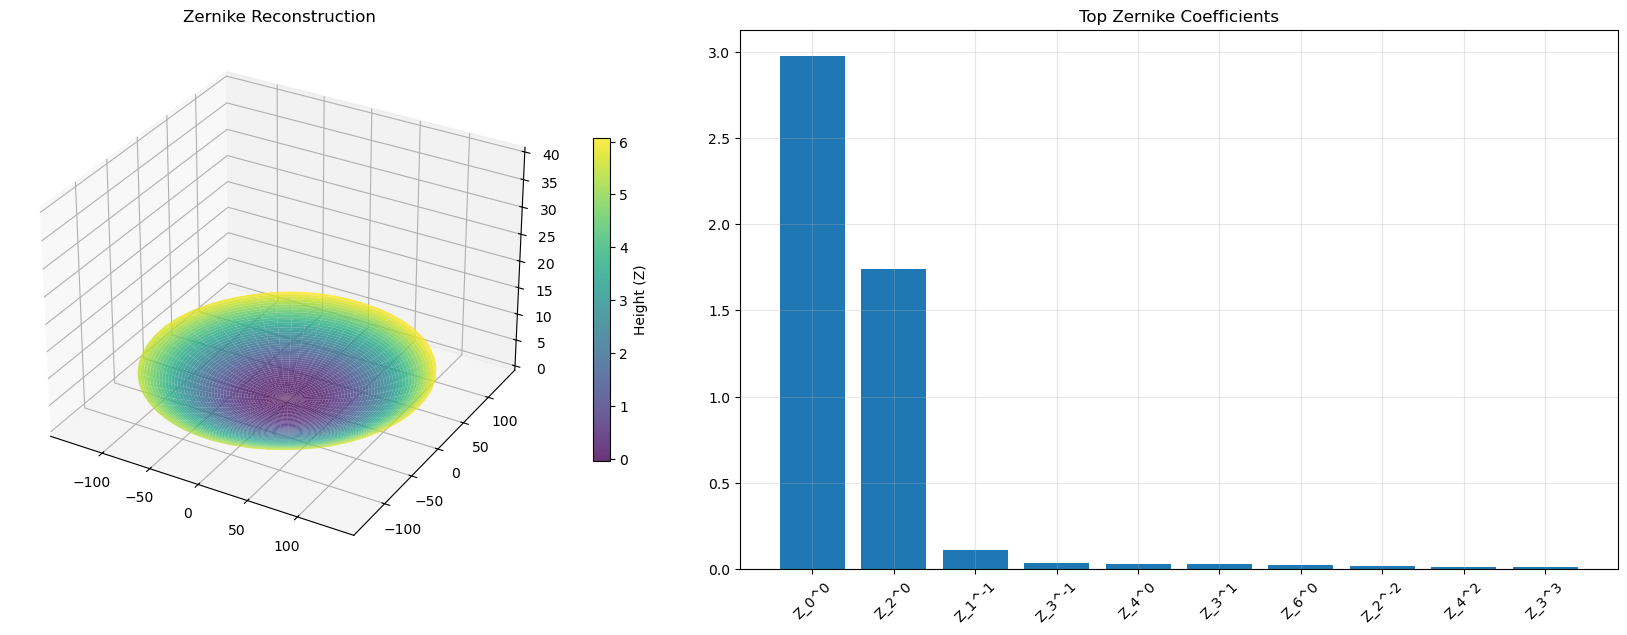

In [384]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def zernike_polynomial(n, m, rho, theta):
    """Calculate Zernike polynomial Z_n^m(rho, theta)"""
    if abs(m) > n or (n - abs(m)) % 2 != 0:
        return np.zeros_like(rho)
    
    # Radial polynomial
    R = np.zeros_like(rho)
    for k in range((n - abs(m)) // 2 + 1):
        coeff = ((-1)**k * sp.factorial(n - k) / 
                (sp.factorial(k) * sp.factorial((n + abs(m)) // 2 - k) * 
                 sp.factorial((n - abs(m)) // 2 - k)))
        R += coeff * rho**(n - 2*k)
    
    # Normalization and angular part
    norm = np.sqrt(n + 1) if m == 0 else np.sqrt(2 * (n + 1))
    Z = norm * R * (np.cos(m * theta) if m >= 0 else np.sin(abs(m) * theta))
    Z[rho > 1] = np.nan
    return Z

def analyze_polar_data(averaged_polar_data, angles, max_order=6):
    """
    Perform Zernike analysis on polar data with parabolic height
    
    Parameters:
    averaged_polar_data: Nested list structure of radial distances
    angles: Array of angles for each ray (in radians)
    max_order: Maximum Zernike order to use
    """

    # Process data into flat coordinate arrays
    r, theta, z = process_polar_data(averaged_polar_data, angles)
    
    # Normalize radius for Zernike polynomials
    max_r = np.max(r)
    r_norm = r / max_r if max_r > 0 else r

    max_radius = 0
    for radii_list in averaged_polar_data:
        if radii_list:
            max_radius = max(max_radius, max(radii_list))
    
    # Generate valid Zernike modes
    modes = []
    for n in range(max_order + 1):
        for m in range(-n, n + 1):
            if (n - abs(m)) % 2 == 0:
                modes.append((n, m))
    
    # Build design matrix
    A = np.zeros((len(r), len(modes)))
    for i, (n, m) in enumerate(modes):
        A[:, i] = zernike_polynomial(n, m, r_norm, theta)
    
    # Fit coefficients
    coefficients = np.linalg.lstsq(A, z, rcond=None)[0]
    
    # Visualization
    fig = plt.figure(figsize=(18, 12))

    
    # 1. Zernike reconstruction
    ax2 = fig.add_subplot(2, 2, 1, projection='3d')
    ax2.set_zlim(0, 40)  # Example range — adjust as needed
    grid_r = np.linspace(0, 1, 50)
    grid_theta = np.linspace(0, 2*np.pi, 50)
    R, Theta = np.meshgrid(grid_r, grid_theta)
    
    Z_recon = np.zeros_like(R)
    for i, (n, m) in enumerate(modes):
        Z_recon += coefficients[i] * zernike_polynomial(n, m, R, Theta)
    
    X = R * max_r * np.cos(Theta)
    Y = R * max_r * np.sin(Theta)
    surf = ax2.plot_surface(X, Y, Z_recon, cmap='viridis', alpha=0.8)
    ax2.set_title('Zernike Reconstruction', fontsize=12)
    plt.colorbar(surf, ax=ax2, shrink=0.6, label='Height (Z)')
    
    # 2. Coefficient analysis
    ax3 = plt.subplot(2, 2, 2)
    top_indices = np.argsort(np.abs(coefficients))[-10:][::-1]
    top_coeffs = coefficients[top_indices]
    top_modes = [modes[i] for i in top_indices]
    mode_labels = [f'Z_{n}^{m}' for n, m in top_modes]
    ax3.bar(range(len(top_coeffs)), np.abs(top_coeffs))
    ax3.set_xticks(range(len(top_coeffs)))
    ax3.set_xticklabels(mode_labels, rotation=45)
    ax3.set_title('Top Zernike Coefficients', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # 3. Interactive Plotly surface
    fig = go.Figure(data=[go.Surface(z=Z_recon, x=X, y=Y, colorscale='Viridis')])
    fig.update_layout(
        title='Interactive Zernike Surface (Plotly)',
        scene=dict(zaxis=dict(range=[-1, 40])),
        width=800,
        height=700
    )
    fig.show()

    
    return coefficients, modes, z

coefficients, modes, z = analyze_polar_data(averaged_polar_data, angles)



### References 

- https://pubmed.ncbi.nlm.nih.gov/17137985/
- https://clspectrum.com/issues/2024/april/orthokeratology-topography-considerations-for-treatment-success/